---

# Chapter 15: Processing Sequences Using RNNs and CNNs

**Tujuan:** Memahami *Recurrent Neural Networks* (RNN), memodelkan data sekuensial untuk forecasting, dan menangani urutan panjang menggunakan RNN dan CNN.

---

## 1. Recurrent Neurons & Layers

* **Recurrent Neuron:** memiliki *state* internal yang diperbarui setiap timestep:

  $
  h_t = \phi(W_x x_t + W_h h_{t-1} + b)
  $

  di mana:

  * $x_t$ = input saat $t$
  * $h_{t-1}$ = *hidden state* sebelumnya
  * $\phi$ = fungsi aktivasi (biasanya `tanh` atau `ReLU`)

* Di Keras tersedia:

  * `SimpleRNN` – sederhana, mudah overfit & terbatas
  * `GRU` – efisien, mengurangi *vanishing gradient*
  * `LSTM` – lebih kompleks, mampu menangani long-term dependency

---

## 2. Forecasting Time Series

Langkah umum dalam time series forecasting menggunakan RNN:

1. **Baseline:**
   Prediksi nilai sebelumnya sebagai nilai berikutnya.

2. **Train/Validation Split:**
   Pisahkan data sekuens secara kronologis (bukan acak).

3. **Windowing:**
   Ubah data sekuens menjadi pasangan input-output:

   $
   [x_{t-n}, x_{t-n+1}, \dots, x_{t-1}] \rightarrow x_t
   $

   Contoh: input 10 langkah ke belakang → prediksi langkah ke-11.

4. **Preprocessing Tambahan:**

   * Normalisasi
   * Reshaping: `X.shape = (samples, timesteps, features)`

---

## 3. Contoh: Forecasting Sine Wave dengan SimpleRNN

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

### 3.1 Buat data: sine wave + noise

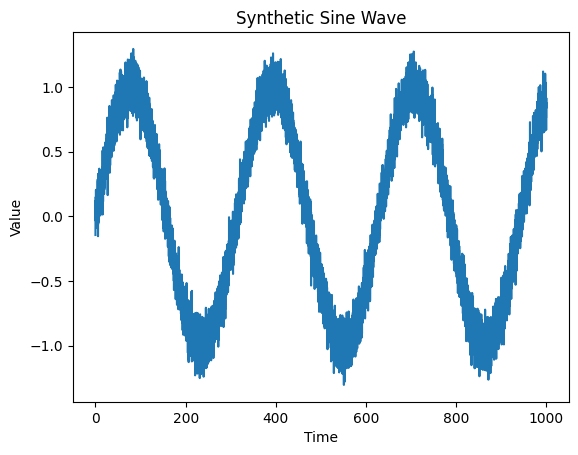

In [2]:
time = np.arange(0, 1000, 0.1)
series = np.sin(0.02 * time) + 0.1 * np.random.randn(len(time))

# Plot
plt.plot(time, series)
plt.title("Synthetic Sine Wave")
plt.xlabel("Time"); plt.ylabel("Value")
plt.show()

### 3.2 Windowing function

In [3]:
def make_windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size+1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size+1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1][..., np.newaxis], w[-1]))
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

# Parameters
window_size = 50
batch_size = 32
shuffle_buffer = 1000

# Split train & val
split = int(len(series) * 0.8)
train_series = series[:split]
val_series   = series[split - window_size:]  # overlap for windows

train_ds = make_windowed_dataset(train_series, window_size, batch_size, shuffle_buffer)
val_ds   = make_windowed_dataset(val_series,   window_size, batch_size, shuffle_buffer)

### 3.3 Baseline: last value

In [4]:
def last_value_baseline(x, y):
    return tf.reduce_mean(tf.abs(y - x[:, -1, 0]))
print("Baseline MAE:", last_value_baseline(*next(iter(val_ds))).numpy())

Baseline MAE: 0.10929522885504785


### 3.4 Bangun model SimpleRNN

In [5]:
model = models.Sequential([
    layers.SimpleRNN(32, input_shape=(window_size,1)),
    layers.Dense(1)
])
model.compile(optimizer='adam', loss='mae')
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 32)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,121 (4.38 KB)

 Trainable params: 1,121 (4.38 KB)

 Non-trainable params: 0 (0.00 B)

### 3.5 Latih model

In [6]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
    249/Unknown 4s 8ms/step - loss: 0.1178

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


249/249 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.1178 - val_loss: 0.0978
Epoch 2/10
 10/249 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0952   

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


245/249 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0908

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0907 - val_loss: 0.0859
Epoch 3/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


243/249 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0878

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0878 - val_loss: 0.0867
Epoch 4/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


244/249 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0886

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0885 - val_loss: 0.0880
Epoch 5/10
246/249 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0881

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0881 - val_loss: 0.0877
Epoch 6/10
 11/249 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0919   

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


242/249 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0886

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0886 - val_loss: 0.0900
Epoch 7/10
 11/249 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0908   

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


246/249 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0892

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0892 - val_loss: 0.0900
Epoch 8/10
241/249 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0888

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0888 - val_loss: 0.0868
Epoch 9/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


246/249 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0874

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


249/249 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0874 - val_loss: 0.0871
Epoch 10/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0877

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0877 - val_loss: 0.0861


### 3.6 Plot learning curves

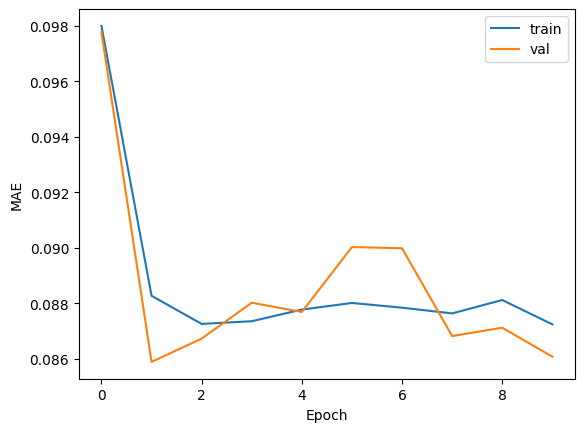

In [7]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch'); plt.ylabel('MAE'); plt.legend()
plt.show()

### 3.7 Evaluasi pada beberapa batch val

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


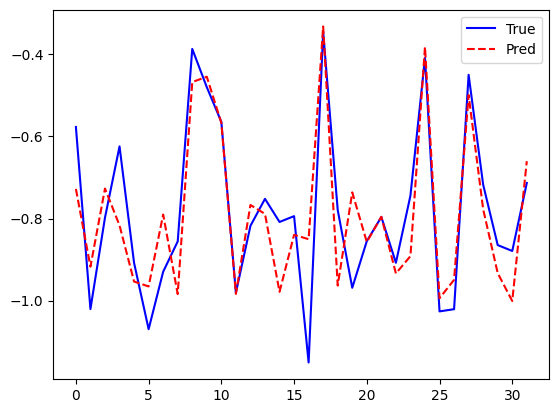

In [8]:
for x_batch, y_batch in val_ds.take(1):
    preds = model.predict(x_batch)
    plt.plot(range(len(y_batch)), y_batch, 'b-', label='True')
    plt.plot(range(len(preds)), preds, 'r--', label='Pred')
    plt.legend(); plt.show()

## 4. Deep RNN & Forecasting Multiple Steps

### 4.1 Deep RNN + forecasting 10 steps ahead

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 32)         │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,658 (29.91 KB)

 Trainable params: 7,658 (29.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
    247/Unknown 6s 11ms/step - loss: 0.3797

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


249/249 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.3790 - val_loss: 0.2134
Epoch 2/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


244/249 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1951

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


249/249 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.1951 - val_loss: 0.1899
Epoch 3/10
  6/249 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.1030

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1634

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


249/249 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.1634 - val_loss: 0.1799
Epoch 4/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


246/249 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1488

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.1489 - val_loss: 0.1773
Epoch 5/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


248/249 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1410

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


249/249 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - loss: 0.1410 - val_loss: 0.1746
Epoch 6/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1355

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


249/249 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.1355 - val_loss: 0.1740
Epoch 7/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


248/249 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1332

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1333 - val_loss: 0.1701
Epoch 8/10
244/249 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1279

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


249/249 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.1280 - val_loss: 0.1681
Epoch 9/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


246/249 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1252

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


249/249 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.1253 - val_loss: 0.1698
Epoch 10/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1242

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


249/249 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.1242 - val_loss: 0.1617


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


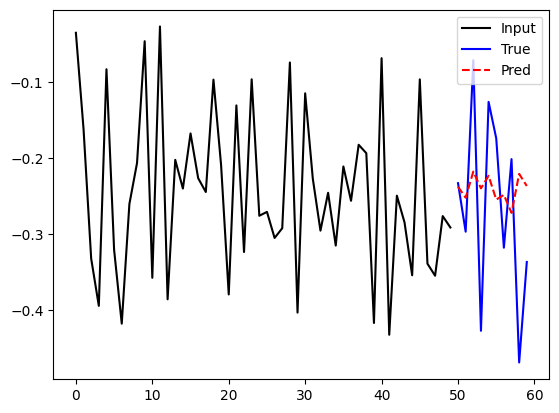

In [9]:
multi_window = 50
horizon = 10

def make_seq2seq_dataset(series, window_size, horizon, batch_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + horizon, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + horizon))
    ds = ds.map(lambda w: (w[:window_size][..., np.newaxis], w[window_size:]))
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds2 = make_seq2seq_dataset(train_series, multi_window, horizon, batch_size)
val_ds2   = make_seq2seq_dataset(val_series,   multi_window, horizon, batch_size)

model2 = models.Sequential([
    layers.LSTM(32, return_sequences=True, input_shape=(multi_window,1)),
    layers.LSTM(16),
    layers.Dense(horizon)
])
model2.compile(optimizer='adam', loss='mae')
model2.summary()

history2 = model2.fit(train_ds2, epochs=10, validation_data=val_ds2)

# Plot horizon predictions on one batch
for x_b, y_b in val_ds2.take(1):
    preds2 = model2.predict(x_b)
    plt.plot(range(multi_window), x_b[:, :, 0][0], 'k-', label='Input')
    plt.plot(range(multi_window, multi_window+horizon), y_b[0], 'b-', label='True')
    plt.plot(range(multi_window, multi_window+horizon), preds2[0], 'r--', label='Pred')
    plt.legend(); plt.show()

## 5. Handling Long Sequences
- Truncated BPTT: windowing

- Stateful RNN: simpan `stateful=True` dan `model.reset_states()`

- Bidirectional RNN untuk konteks ke depan & ke belakang

# Ringkasan Chapter 15
1. RNN (SimpleRNN/LSTM) cocok untuk data sekuens.

2. Pipeline: windowing → dataset → model → forecast.

3. Baseline sederhana (last value) harus dilampaui.

4. Deep RNN & seq2seq untuk multi‑step forecasting.

5. Stateful & bidirectional RNN untuk urutan panjang.